# Oblig stk4021
Simen Eide

## Load data and libraries

In [2]:
import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import gamma, uniform, beta, norm
from scipy.optimize import minimize
def mc_integrate(f, low = 0, high = 1, samples = 100000):
    u = np.random.uniform(low = low, high = high, size=samples)
    pmf = f(u)*(high-low)
    return np.mean(pmf)

%matplotlib inline
raw = pd.read_csv("fr1_data")
raw.head(2)

,Unnamed: 0,name,birth,death,term.start,term.end,executed,girondin,number.languages
0,1,Jerome Petion de Villeneuve,1756.008333,1794.466667,1792.722222,1792.761111,1,1,15
1,2,Jean-Francois Delacroix,1753.258333,1794.263889,1792.761111,1792.800000,1,0,4


# Part 1 - Life-length after presidency

## 1a)
Find the data and define the variable y as specified above. Display a
histogram of these time points. The histogram should look like the one
displayed in Figure 1.

---

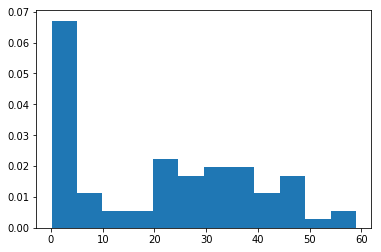

In [2]:
raw['postpres'] = raw['death'] - raw['term.end']
y = raw['postpres'].values
_ = plt.hist(y, density=True, bins = 12)

## 1b)

Find the density of the two-parameter weibull model. CDF:

---

$$ F(y|a,b) = 1 - e^{-(y/a)^{b})} $$

Get density by taking derivative w.r.t. y:
$$ \frac{dF}{dy} = -exp(-(y/a)^{b})) (-b) (\frac{y}{a})^{b-1} (\frac{1}{a}) $$

Rearranging:
$$ f(y |a,b) = \frac{dF}{dy} = e^{-(y/a)^{b}} (\frac{by^{b-1}}{a^b}) $$


## 1c) 
We are Bayesian statisticians today, and we need to specify a prior for
the unknown parameters a and b above. Assume first that we have not
yet managed to get hold of a suitable expert, and that we therefore wish
to use the ‘non-informative’ Jeffreys prior for the Weibull model. Show
that the Jeffreys prior, p0(a, b), is proportional to 1/a.

---
#### Jeffrey's prior
Jeffrey' prior is proportional to $\sqrt{det(I(\theta)}$, where $I(\theta) = - E[\frac{\partial^2}{\partial \theta ^2} lnP(y|\theta) | \theta ] $ and $\theta = (a,b)$.

#### Distribution of lambda
Consider the transformation $\lambda = f(y,a,b) = (\frac{y}{a})^b$. We want to know the distribution of $\lambda$.

We know that 

$$P_{\lambda}(\lambda) = |J| Pr_y( f^{-1}(\lambda))$$

Using functions above we get 

$$ f^{-1}(v) = a v^{1/b}$$

$$ |J| = |\frac{d f^{-1}(x)}{dx}| = \frac{a}{b} x^{\frac{1-b}{b}}$$

$$ Pr_y( f^{-1}(\lambda)) = Pr_y( a \lambda^{1/b})
= e^{-\lambda} b \frac{a^{b-1}}{a^b} \lambda^{\frac{b-1}{b}}  
= e^{-\lambda} \frac{b}{a} \lambda^{\frac{b-1}{b}}$$
$$$$


Combining these gives

$$P_{\lambda}(\lambda) 
= \frac{a}{b} \lambda^{\frac{1-b}{b}} e^{-\lambda} \frac{b}{a} \lambda^{\frac{b-1}{b}}
= e^{-\lambda} \lambda^{\frac{1-b}{b} + \frac{b-1}{b}} $$

$$P_{\lambda}(\lambda) = e^{-\lambda}$$

Hence, $\lambda = (\frac{y}{a})^b$ is exponentially distributed.


## 1d)
Assume now (for simplicity) that the parameter b happens to be known
and equal to 0.9. 

- Find the posterior distribution for a using Jeffreys prior
above. Here you may find it useful to use some numerical integration
routine, for instance integrate in R. 
- Display the posterior density for
a and find the posterior mode. 
- Use this point-estimate for a to display
the estimated Weibull density curve along with the histogram of the
data. This should look like Figure 1. 
- Comment briefly on how you think
the model fits the data.

----
The likelihood

$$ P(y|a,b) = \prod_{i=1}^{73} e^{-(y_i/a)^{b}} (\frac{by_i^{b-1}}{a^b}) $$

The posterior is propotional to

$$ P(a|y) \propto P(y |a,b) * \frac{1}{a} $$

We can find the normalizing constant by numerically integrating $P(a|y)$ by monte carlo integration:

In [3]:
# Define non-normalized prior, likelihood and posterior:

def weibull_density(y,a,b):
    return np.exp(-(y/a)**b) * b * y**(b-1) / a**b

b0 = 0.9
def nonnorm_likelihood(a, b = b0): 
    l = weibull_density(y,a,b)
    return l.prod()

def nonnorm_prior(a,b = b0):
    return 1/a

nonnorm_posterior = lambda a: nonnorm_likelihood(a,b0)*nonnorm_prior(a,b0)
nonnorm_posterior = np.vectorize(nonnorm_posterior)

In [4]:
## Integrate to get posterior:
def mc_integrate(f, low = 0, high = 1, samples = 100000):
    u = np.random.uniform(low = low, high = high, size=samples)
    pmf = f(u)*(high-low)
    return np.mean(pmf)

const = mc_integrate(nonnorm_posterior, low = 10, high = 30)
print(const)
posterior = lambda a: nonnorm_posterior(a)*1/const

5.310223789352761e-130


Visualize the posterior:


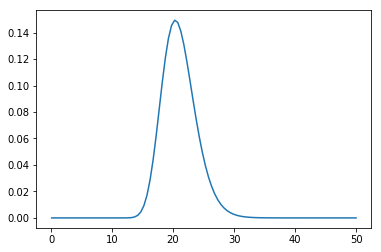

In [5]:
print('Visualize the posterior:')
a_ = np.linspace(0.1,50, 100)
p = posterior(a_)
_ = plt.plot(a_,p)

In [6]:
## Find the mode:
a_mode = a_[p.argmax()]
print("The mode of the posterior is {}.".format(a_mode))

The mode of the posterior is 20.261616161616164.


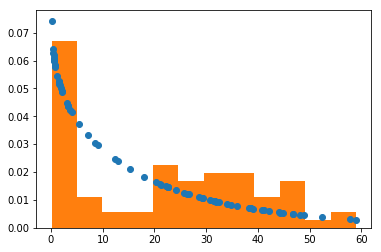

In [7]:
### Visualize the mode point estimate of the distribution
# Plot on same area as observed data
w_density = weibull_density(y,a = a_mode, b = 0.9)

plt.plot(y,w_density, "o")
_ = plt.hist(y, density=True, bins = 12)

#### Comments on model fit
The fit seems to work at either end of the scale, but there seems to be something wrong from y=5 to y=20.
It seems like quite a few of the leaders died shortly after their period terminated, whereas other lived for a long time.

## 1e) 
The histogram of post-presidency life-times is rather unusual-looking,
and somewhat bimodal, therefore we will now attempt a more complex
model, a mixture of two Weibull distributions. The density takes the
following form,

g(y|a1, b1, a2, b2, ρ) = ρf(y|a1, b1) + (1 − ρ)f(y|a2, b2) for y > 0.

Here f(·) is the Weibull density function given in (b), a1, b1, a2 and b2
are positive parameters, and ρ is the mixture parameter, taking values
between 0 and 1. Programme the log-likelihood function
`n(a1, b1, a2, b2, ρ) = Xn
i=1
log g(yi
|a1, b1, a2, b2, ρ),
and find the maximum likelihood estimates for the n = 73 life-times
using a suitable numerical optimiser. Good starting values are important
in this case, you may use (2, 1, 35, 3, 0.5). Add the estimated density
curve to the same figure as in the previous question and comment briefly

In [8]:
def twoWeibullDensity(y, a1,b1,a2,b2,rho):
    return rho*weibull_density(y,a1,b1) + (1-rho)*weibull_density(y,a2,b2)


In [9]:
par0 = np.array([2,1,35,3,0.5])

In [10]:
lik = lambda par : sum(np.log(twoWeibullDensity(y,par[0],par[1],par[2],par[3],par[4])))

In [11]:
opt = minimize(lambda par: -lik(par),par0, method='nelder-mead')
par = opt.x
par

array([ 2.31358752,  1.12873223, 36.58008183,  2.97417611,  0.36314301])

In [12]:
mle = twoWeibullDensity(y, par[0],par[1],par[2],par[3],par[4])

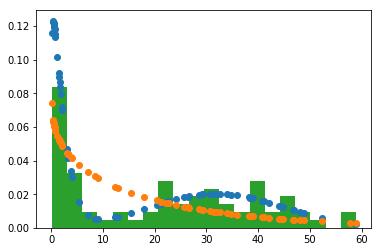

In [13]:
plt.plot(y,mle, "o")
plt.plot(y,w_density, "o")
_ = plt.hist(y, density=True, bins = 20)

The bimodal distribution seems to much better fit the data as it has a significant dip for $y \in (5,20)$.

## 1f) 
Assume we have consulted with Mrs. Capet, an expert in revolutionary
history, and she has given us the following prior for the full parameter
vector $(a1, b1, a2, b2, ρ)$: 
let the five parameters be independent and
$$a1 ∼ Gamma(3, 1)$$
$$b1 ∼ Unif(0.5, 4)$$
$$a2 ∼ Gamma(20, 1)$$
$$b2 ∼ Gamma(10, 2)$$
$$p ∼ Beta(α, β) $$

Further, let the prior for ρ be a $Beta(α, β)$, such that $E(ρ) = 0.2$ and
$Var(ρ) = 0.04^2$. 

- Find the corresponding α, β values (if you do not
manage this part, use α = 2 and β = 5 in the following). 
- Using the prior
above, draw 1000 random post-presidency life-times from the associated
prior predictive distribution, and display them in a histogram. 
- Comment
briefly.


---


In [14]:
### get beta distr with correct alpha and beta
p0 = np.array([2,5]) #initial cond.
f = lambda p: (beta.mean(p[0], p[1])- 0.2)**2 + (beta.var(p[0], p[1]) - 0.04**2)**2
opt = minimize(f, p0, tol = 1e-10, method='nelder-mead')
p = opt.x
print("ESTIMATE:")
print("alpha: {}, beta: {}".format(p[0],p[1]) )
print("gives mean {} and variance {}^2.".format(beta.mean(p[0], p[1]), np.sqrt(beta.var(p[0], p[1]))))

ESTIMATE:
alpha: 19.79999999999069, beta: 79.19999999996335
gives mean 0.1999999999999988 and variance 0.040000000000009105^2.


#### Draw 1000 from predictive distribution

First inverse the weibull so we can sample from it by using unif random:

$$ F^{-1}(X) = \alpha (-ln(1-X))^{1/b}$$

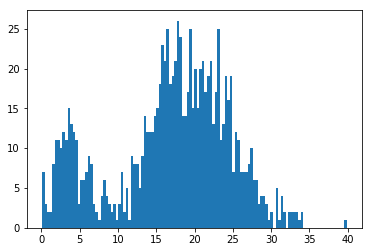

In [15]:
def weib_invcdf(x, a,b):
    return a*(-np.log(x))**(1/b)

n = 1000
a1_ = gamma.rvs(3,2, size=n)
b1_ = uniform.rvs(0.5,3.5, size=n) # seems like second argument is the added diff
a2_ = gamma.rvs(20,1, size=n)
b2_ = gamma.rvs(10,2, size=n)
rho_ = beta.rvs(p[0],p[1], size = n)

u = np.random.uniform(0,1,size = n)
u2 = np.random.uniform(0,1,size = n)
prior_sample = weib_invcdf(u,a1_,b1_)*(u2 < rho_) + (1-(u2 < rho_))*weib_invcdf(u,a2_,b2_)
_ = plt.hist(prior_sample, bins = 120)

The posterior has managed to get the shape of the real data fairly well, but seems to be a bit weak in the tails.

## 1g) 
Set up an MCMC scheme in order to draw samples from the posterior
for (a1, b1, a2, b2, ρ) using the prior specified above. Display a histogram
of posterior draws for ρ. 

- Give the posterior mean and 95% posterior
interval for the following two quantities: 
 + λ, the probability of dying
within 5 years of the end of presidency, and 
 + γ, the probability of living
longer than 40 years after the end of presidency. Compare these results
with empirical estimates of λ and γ.

---
Likelihood is the twoWeibull distr
priors are the product of each prior distr (indep.)

In [16]:
# likelihood

lik = lambda par : (twoWeibullDensity(y,par[0],par[1],par[2],par[3],par[4])).prod()
prior = lambda par: gamma.pdf(par[0], 3,2) * uniform.pdf(par[1], 0.5,3.5) * gamma.pdf(par[2],20,1) * gamma.pdf(par[3],10,2)*beta.pdf(par[4],p[0],p[1])
posterior = lambda par: prior(par)*lik(par)

# This can be done in terms of loglikelihoods as well, gave same results
#  (remember to transform byexp etc in algorithms)
logprior = lambda par:  (
    np.log(gamma.pdf(par[0], 3,2)) + 
    np.log(uniform.pdf(par[1], 0.5,3.5)) +
    np.log(gamma.pdf(par[2],20,1)) +
    np.log(gamma.pdf(par[3],10,2)) +
    np.log(beta.pdf(par[4],p[0],p[1])) )

loglik = lambda par: np.sum(np.log(twoWeibullDensity(y,par[0],par[1],par[2],par[3],par[4])))
logpost = lambda par: logprior(par) + loglik(par)


In [17]:
## Metropolis-hastings
n = int(5e4)
parsize = 5
theta = np.zeros((n,parsize))
theta[0,] = par # start in mle point for simplification
for i in range(1,n):
    theta_candidate = theta[i-1,] + (uniform.rvs(size=5)-0.5)*0.1
    theta_candidate = theta_candidate.clip(min=0.001)
    ratio = posterior(theta_candidate)/posterior(theta[i-1,])
    prob_accept = min(1, ratio)
    if np.isnan(ratio):
        print("Found NAN value.")
        break
    
    accept = np.random.uniform() < prob_accept

    theta[i] = theta_candidate if accept else theta[i-1]

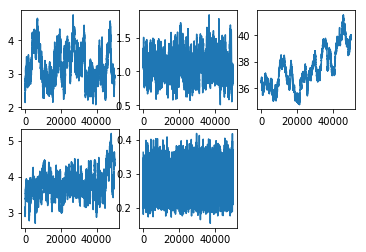

In [18]:
#### Get trajectories
for i in range(5):
    plt.subplot(2,3,i+1)
    _ = plt.plot(theta[:,i])

#### Histogram of rho

'E[rho | data, prior] = 0.2807'

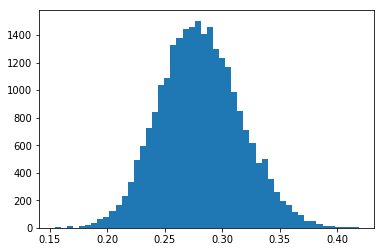

In [19]:
_ = plt.hist(theta[int(n/2):,4], bins = 50)
f"E[rho | data, prior] = {np.round(np.mean(theta[int(n/2):,4]),4)}"

##### Histogram of all

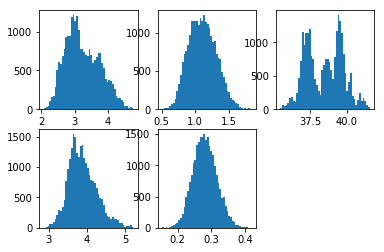

In [20]:
#### Get histograms
for i in range(5):
    plt.subplot(2,3,i+1)
    _ = plt.hist(theta[int(n/2):,i], bins = 50)

In [21]:
# Sample from posterior
# burnout half of trajectories:
post_samples = theta[int(n/2):]
n = post_samples.shape[0]
a1_ = post_samples[:,0]
b1_ = post_samples[:,1]
a2_ = post_samples[:,2]
b2_ = post_samples[:,3]
rho_ = post_samples[:,4]

In [22]:
def weibull_cdf(y, a, b):
    return 1. - np.exp(-(y / a)**b)
def weibull_mixture_cdf(y, a1, b1, a2, b2, p):
    return p * weibull_cdf(y, a1, b1) + (1. - p) * weibull_cdf(y, a2, b2)

In [23]:
F5 = weibull_mixture_cdf(5, a1_, b1_, a2_, b2_, rho_)
F40 = 1 - weibull_mixture_cdf(40, a1_, b1_, a2_, b2_, rho_)
F5.sort()
F40.sort()

In [24]:
print("Post mean, q5 and q95 for living less than five years:")
print(np.mean(F5), F5[int(0.025*len(F5))], F5[int(0.975*len(F5))])
print('---')
print("Post mean, q5 and q95 for living more than 40 years:")
print(np.mean(F40), F40[int(0.025*len(F40))], F40[int(0.975*len(F40))])

Post mean, q5 and q95 for living less than five years:
0.22550514679161396 0.16837615225333682 0.29184672190343575
---
Post mean, q5 and q95 for living more than 40 years:
0.22541064131261176 0.16316267645342775 0.2906360736717557


In [25]:
### EXTRA MATERIAL: TRIED TO FIND OUT USING POSTERIOR PREDICTIVE...
# prob dying within 5 years:

def sample_one_post_predictive():
    u = np.random.uniform(0,1,size = n)
    u2 = np.random.uniform(0,1,size = n)
    post_pred = weib_invcdf(u,a1_,b1_)*(u2 < rho_) + (1-(u2 < rho_))*weib_invcdf(u,a2_,b2_)
    return post_pred

post_pred = sample_one_post_predictive()
# _ = plt.hist(post_pred, bins = 50, density =True)
post_pred = sample_one_post_predictive()
print(f" The posterior probability of dying within 5 years: {np.mean(post_pred <=5)}")
print(f" The empirical probability of dying within 5 years: {np.mean(y <=5)}")

 The posterior probability of dying within 5 years: 0.22352
 The empirical probability of dying within 5 years: 0.3287671232876712


## 1h) 
When conducting statistical analyses our goal is often to make statements
about a certain unobserved population. Discuss briefly to what extent
the available dataset offers any possibility for such generalisations.

# Part 2 – Cause of death
While working with Part 1 you might have guessed that there are in fact
two groups of presidents in the dataset (or equivalently, that there are
two different processes governing the life lengths of the presidents): some presidents were executed during the revolution, while the rest survived the
revolutionary period and died of natural causes. Now we will look more
carefully at the cause of death, by studying the variable ‘executed’ which
indicates whether the president was executed (1), or not (0)2
.

## 2a) 
Consider the variable z, the number of executed presidents among the
n = 73. Assume first a simple binomial model, z ∼ Bin(n, θ), where
θ is the probability of being executed. Before looking at the value of
z in the dataset, use your knowledge (or lack of thereof) about the
French revolution to specify a prior for θ. You can choose a prior from
any parametric family you find suitable. Give a couple of sentences
explaining your reasoning.

---

The French revolution is known to have caused a considerable amount of executions, also in the higher ranks of society. The executions would probably happen whenever the president came in disfavour in the National Convention (NC). Since they believed in democratic principles, you probably needed a majority in the NC to convict someone to death. If there were two stable blocks, this would happens less than 50\% of the time. Then some presidents may try to grab power and be in disfavour of all in the NC. However, other than this I do not have any strong prior beliefs. Since execution has some moral attachments, I will guess an expected value of 10% with large uncertainties.

It is suitable for computational reasons to specify a beta prior in order to get favourable conjugacy properties.  Using the reparameterized beta distribution:

$$ \alpha = K_0 \theta_0 $$
$$ \beta = K_0(1-\theta_0) $$

We guess $\theta_0 = 0.1$ and $K_0 = 2$, giving:

$$ P(\theta) = Beta(K_0 \theta_0, K_0 (1-\theta_0)) $$
$$ P(\theta) = Beta(0.2, 1.8) $$

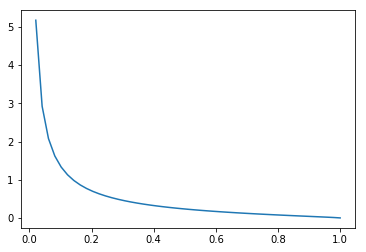

In [2]:
x = np.linspace(0,1)
K0 = 2
theta0 = 0.1
a = K0*theta0
b = K0*(1-theta0)
pdf = beta.pdf(x, a, b)
plt.plot(x,pdf)

## 2b) 
Find the posterior distribution $p(θ|z)$ using the prior you chose in (a).
Give the posterior mean and 95% posterior interval for the probability
of execution.

---

The likelihood $P(n|\theta) = Bin(73,\theta)$.

We can show that the beta distribution is a conjugacy prior to the binomial since the posterior is:

$$
P(\theta | k) \propto Bin(k|\theta) Beta(\theta| \alpha, \beta) \\
= \theta^k (1-\theta)^{n-k}  \theta^{\alpha-1} (1-\theta)^{\beta-1} \\
= \theta^{k + \alpha-1} (1-\theta)^{n - k + \beta-1} \\
\propto Beta(k+\alpha, n+ \beta - k) $$

In [3]:
k = raw['executed'].sum()
n = raw.shape[0]
print(f"Exeuctions in data: {k}, Total no. presidents:  {n}")

a_post = k+a
b_post = n+b-k
def minimize_cdf(cdf_lvl):
    opt = minimize(lambda x: (beta.cdf(x, a_post, b_post) - cdf_lvl)**2, x0 = 0.5, method='nelder-mead')
    return float(opt.x)

print(f"Posterior mean: {a_post/(a_post+b_post)}")
print(f"Posterior interval 95%:[{minimize_cdf(0.025)},{minimize_cdf(0.975)}]")

Exeuctions in data: 18, Total no. presidents:  73
Posterior mean: 0.24266666666666667
Posterior interval 95%:[0.15322265624999967,0.3451171874999999]


## 2c) 
Now, we want to investigate some covariates and their potential influence
on the probability of being executed. Logistic regression offers a natural
extension of the binomial model above to incorporate covariates. Let
wi be the vector of 1 and 0 indicating whether a certain president was
executed or not (this is the column named ‘executed’ in the dataset).
Assume
$$ wi ∼ Bin(1, θ_i) $$ 
for i = 1, . . . , 73.

With

$$ θ_i = Pr(executed|x_{1,i}, x_{2,i}) = H(α + β_1x_{1,i} + β_2x_{2,i}) \\
= \frac{exp(α + β_1x_{1,i} + β_2x_{2,i})}   {1 + exp(α + β_1x_{1,i} + β_2x_{2,i})} 
$$



where H(·) is the logistic transform. Here $x_{1,i}$ is the covariate ‘girondin’
and $x_{2,i}$ is the covariate ‘number.languages’. 

The first covariate is a
vector of 1 and 0, where 1 indicates that president i belonged to a
certain political faction of the First Republic, la Gironde (the other
main factions were Montagne and Marais). 

The second covariate is a
number between 1 and 87 which indicates the number of languages in
which there are Wikipedia articles about president i. This covariate
could be interpreted as a proxy for the importance of president i (in 2018, which of course may be rather different from his importance in
1792). Show that the log-likelihood function is

(...)

where θi
is a function of α, β1, β2 (as defined above). 


Programme this
log-likelihood function and find its maximisers. Display two curves of
estimated probability as a function of x2,


---

Assuming that all observations are independent conditional on x, the log likelihood function can be written as 

$$ loglik = \sum_{i=1}^{73} ln P(w_i | \theta_i) $$

For each i, we can write the binomial(1) (or Bernoulli) distribution as:

$$ P(w_i | \theta_i) = \theta_i^{w_i} (1-\theta_i)^{1-w_i} $$
and log of this:
$$ ln(P(w_i | \theta_i)) = w_i ln(\theta_i) + (1-w_i)ln(1-\theta_i) $$

Combining this with the first equation gives:

$$ loglik = \sum_{i=1}^{73}  w_i ln(\theta_i) + (1-w_i)ln(1-\theta_i) $$

#### Optimize to get maximum likelihood and plot curves

In [52]:
x1 = raw.girondin.values
x2 = raw['number.languages'].values
w = raw.executed.values
def get_theta(x1,x2, a,b1,b2):
    lin = np.exp(a + b1*x1 + b2*x2)
    return lin /(1+lin)

def loglikelihood(a, b1, b2):
    theta_ = get_theta(x1,x2,a = a, b1 = b1, b2 = b2)
    ind_obs = (w*np.log(theta_) + (1-w)*np.log(1-theta_))
    return ind_obs.sum()

opt = minimize(lambda x: -loglikelihood(x[0],x[1],x[2]), x0 = [0, 0.5,0.1], method='BFGS')
a_hat, b1_hat, b2_hat = opt.x
print(f"Optimization worked: {opt.success}")
print(f"Optimal values: a={a_hat}, b1={b1_hat}, b2={b2_hat}")
print(f"loglik: {loglikelihood(a_hat,b1_hat,b2_hat)}")

Optimization worked: True
Optimal values: a=-2.162689356671675, b1=1.9206928462884725, b2=0.040793404811708074
loglik: -34.66172225090626


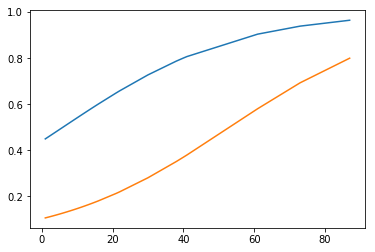

In [54]:
x2sort = np.sort(x2)
theta_G = get_theta(x1 = 1, x2 = x2sort, a = a_hat, b1 = b1_hat, b2 = b2_hat)
theta_O = get_theta(x1 = 0, x2 = x2sort, a = a_hat, b1 = b1_hat, b2 = b2_hat)

plt.plot(x2sort, theta_G)
plt.plot(x2sort, theta_O)

## 2d) 
Again we have visited Mrs. Capet in order to obtain some informative
prior distributions. This time she gave us the following information;

- the ‘baseline’ probability of execution follows a certain Beta
distribution: 

$$θ_0 = \frac{exp(a)}{1+exp(a)} ∼ Beta(2, 5) $$

- the odds-ratio of execution for a member of la Gironde compared to
a non-member follows a certain Gamma distribution, this translates
to 


$$exp(β_1) ∼ Gamma(9, 2) $$

- the odds-ratio of execution for a president with Wikipedia article in
one more language follows another Gamma distribution: 

$$ exp(β_2) ∼ Gamma(1, 0.5) $$

Set up an MCMC to draw from the posterior distribution of (α, β1, β2)
using the specified prior. Record posterior means and 95% intervals for
the three model parameters, and compare with values obtained by the
‘Lazy Bayesian’ strategy, that of normal approximations from maximum
likelihood theory.

---



From the exercise, we assume that $\alpha = a$.

We have that the posterior is defined as 

$$ P(\alpha, \beta_1, \beta_2 | data) \propto P(data | \alpha, \beta_1, \beta_2) * P(\alpha, \beta_1, \beta_2) $$

We have the likelihood from previous exercise:

$$ ln P(data | \alpha, \beta_1, \beta_2) =  \sum_{i=1}^{73}  w_i ln(\theta_i) + (1-w_i)ln(1-\theta_i) $$

$$ θ_i = H(α + β_1x_{1,i} + β_2x_{2,i})$$

Assume that the priors are independent:

$$ P(\alpha, \beta_1, \beta_2) = P(\alpha) P(\beta_1) P(\beta_2) $$

Posterior is then: 
\begin{equation}
lnP(\alpha, \beta_1, \beta_2 | data) \propto \sum_{i=1}^{73}  w_i ln(\theta_i) + (1-w_i)ln(1-\theta_i) + 
lnP(\alpha) + lnP(\beta_1) + lnP(\beta_2)
\end{equation}

To get $P(\beta_1)$ we need to translate variables. 
We know that 

  $$P_u = P(exp(\beta_1)) = Gamma(9,2)$$.
  
We need to know $P(ln(U))$. Setting $ v = ln(u)$ we know that

$$ P_v = |J| P_u (exp(v) ) = exp(\beta_1) Gamma(exp(\beta_1), 9, 2)$$

$$ P_{\beta_1} = exp(\beta_1) Gamma(exp(\beta_1), 9, 2)$$


Similarly for $\beta_2$ we get 

$$ P_{\beta_2} = exp(\beta_2) Gamma(exp(\beta_2), 1, 0.5)$$


For a we have that $\theta_0 = H(a) ~ Beta(2,5)$.
We want to find the distribution of $a = ln(\frac{1}{1-\theta_0})$.
Then we know that:

$$ P_a(a) = |J| P_{\theta_0}(H(a)) $$

where 
$$|J| = \frac{d}{da} H(a) = \frac{d}{dv} \frac{e^a}{1+e^a} $$ 
$$|J| = \frac{e^a}{(1+e^a)^2}  $$

so
$$ P_a(a) = \frac{e^a}{(1+e^a)^2} Beta(\frac{e^a}{1+e^a}, 2,5) $$


0.9936253929992874
0.9926213195911356
0.9895449467767611


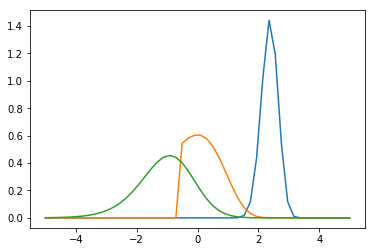

In [56]:
# Coded from above:
b1pdf = lambda x: np.exp(x) *gamma.pdf(np.exp(x), 9, 2)
b2pdf = lambda x: np.exp(x) *gamma.pdf(np.exp(x), 1, 0.5)
apdf = lambda x: np.exp(x)/((1 + np.exp(x))**2) * beta.pdf(np.exp(x) /(1+np.exp(x)), 2, 5)
def posterior_log(a,b1,b2):
    logprior = np.log(b1pdf(b1)) + np.log(b2pdf(b2)) + np.log(apdf(a))
    loglik = loglikelihood(a, b1, b2)
    return logprior + loglik

# Check soundness of prior pdf's:
for f in [b1pdf, b2pdf, apdf]:
    x = np.linspace(-5,5)
    pdf = f(x)
    plt.plot(x,pdf)
    print(mc_integrate(b1pdf, -5, 5))

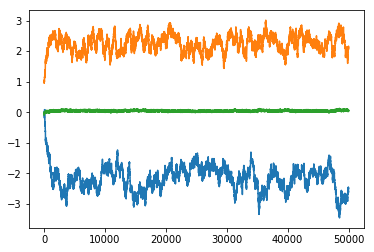

In [7]:
## Metropolis hasting MCMC:
steps = int(5e4)
d = 3
delta = 0.1

par = np.zeros((steps,3))
par[0,] = [0, 1, -0.1] #Some admissable starting values
# also tried with mls initial vals with approx same result: [-2.1626970, 1.92067475, 0.0407935670]

for t in range(1, steps):
    cand = par[t-1,] + uniform.rvs(-0.5, 1,size=d)*delta
    
    logdiff = posterior_log(cand[0], cand[1], cand[2]) - posterior_log(par[t-1,0], par[t-1,1], par[t-1,2])
    ratio = np.exp(logdiff)
    
    if uniform.rvs() < ratio:
        par[t,] = cand
    else:
        par[t,] = par[t-1,]
        
for i in range(d):
    plt.plot(par[:,i])

a: 	 mean=-2.166769098876545	  95% interval: [-2.9672574269856336, -1.5663180352703803]
b1: 	 mean=2.2621286406481325	  95% interval: [1.765584376387526, 2.7419447289101146]
b2: 	 mean=0.04084483992062008	  95% interval: [0.008311089882537193, 0.07961755040411006]


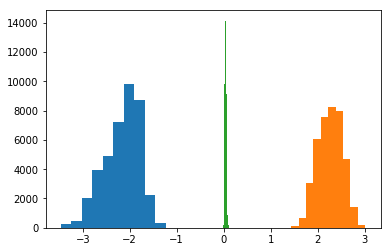

In [8]:
post_samples = par[10000:,] #burnout
for i, name in enumerate(["a","b1","b2"]):
    dsort = np.sort(post_samples[:,i])
    print("{}: \t mean={}\t  95% interval: [{}, {}]".format(name, np.mean(dsort), dsort[int(0.025*len(dsort))], dsort[int(0.975*len(dsort))]))
    plt.hist(post_samples[:,i])

#### Compare with lazy bayes NBNB
The full posterior can be written as

\begin{equation}
lnP(\alpha, \beta_1, \beta_2 | data) = \sum_{i=1}^{73}  w_i ln(\theta_i) + (1-w_i)ln(1-\theta_i) + 
lnP(\alpha) + lnP(\beta_1) + lnP(\beta_2)
\end{equation}

$$ P_a(a) = \frac{e^a}{(1+e^a)^2} Beta(\frac{e^a}{1+e^a}, 2,5) $$
$$ P_{\beta_2} = exp(\beta_2) Gamma(exp(\beta_2), 1, 0.5)$$
$$ P_{\beta_1} = exp(\beta_1) Gamma(exp(\beta_1), 9, 2)$$

In [83]:
# Maximize the posterior to get mode and hessian values:
# start in mle optimal point.
opt = minimize(lambda x: -posterior_log(x[0],x[1],x[2]), 
               x0 = [-2.1626970, 1.92067475, 0.0407935670], method='BFGS')

# Get hessian:
mode = opt.x
invI = opt.hess_inv 
# Since we have minimized the negative logP, the inverse hessian from the optimization  is inv(-H)

# Evaluate the approximation numerically because we are lazy:
lazy_post = np.random.multivariate_normal(mode, H, size = 1000)

a: 	 mean=-2.1365192161820254	  95% interval: [-2.8578446099293027, -1.4107531671468743]
b1: 	 mean=2.274295154452553	  95% interval: [1.784203739915434, 2.7882690296087898]
b2: 	 mean=0.03924296600446917	  95% interval: [0.00666155992294791, 0.07330321202700735]


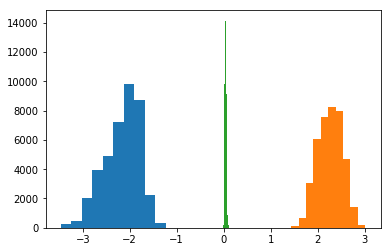

In [84]:
for i, name in enumerate(["a","b1","b2"]):
    dsort = np.sort(lazy_post[:,i])
    print("{}: \t mean={}\t  95% interval: [{}, {}]".format(name, np.mean(dsort), dsort[int(0.025*len(dsort))], dsort[int(0.975*len(dsort))]))
    plt.hist(post_samples[:,i])

## 2e)
Below is the posterior 5% and 95% quantile, as well as the posterior mean for different values of x2 (and x1).

A couple of points can be remarked:
- For less famous presidents (low $x_2$), there is significant higher probabilities of being executed if you are a member of la Gironde.
- For more famous presidents (high $x_2$), the uncertainty is in general higher. It is also more unclear whether membership in la Gironde gives you a higher execution probability, as the 90% bands intersects.

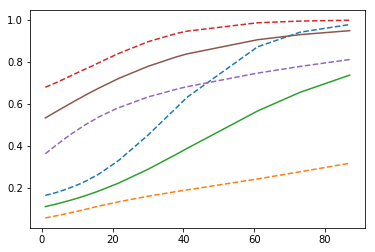

In [36]:
for x1_val in [0,1]:
    q95 = np.zeros(len(x2sort))
    q05 = np.zeros(len(x2sort))
    avg = np.zeros(len(x2sort))
    for i, val in enumerate(x2sort):
        pos = get_theta(x1 = x1_val, x2 = val, 
                        a = post_samples[:,0], 
                        b1 = post_samples[:,1], 
                        b2 = post_samples[:,2])
        q95[i] = np.quantile(pos,0.95)
        q05[i] = np.quantile(pos,0.05)
        avg[i] = np.mean(pos)

    plt.plot(x2sort, q95, linestyle = 'dashed')
    plt.plot(x2sort, q05, linestyle = 'dashed')
    plt.plot(x2sort, avg)

## 2f)

In [39]:
raw.head(2)

,Unnamed: 0,name,birth,death,term.start,term.end,executed,girondin,number.languages
0,1,Jerome Petion de Villeneuve,1756.008333,1794.466667,1792.722222,1792.761111,1,1,15
1,2,Jean-Francois Delacroix,1753.258333,1794.263889,1792.761111,1792.800000,1,0,4


In [45]:
theta_hat = np.zeros(len(x1))

for i, (x1_val, x2_val) in enumerate(zip(x1,x2)):
        pos = get_theta(x1 = x1_val, x2 = x2_val,
                        a = post_samples[:,0],
                        b1 = post_samples[:,1],
                        b2 = post_samples[:,2])
        theta_hat[i] = pos.mean()

In [48]:
yhat = theta_hat >= 0.3

In [85]:
np.abs(yhat-raw['executed']).mean()

0.2465753424657534